In [32]:
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)


import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'.keras.__version__: {tensorflow.keras.__version__}' )
# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 1.15.0
.keras.__version__: 2.2.4-tf


### 데이터 로더

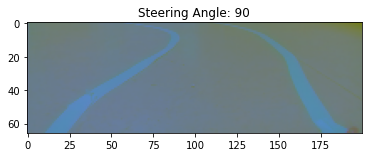

image_path: ../video\_00000_090.png
Steering Angle: 90


In [33]:
# 비디오 이미지 파일이 있는 디렉토리 설정
data_dir = '../video'
# 디렉토리 내의 파일 목록
file_list = os.listdir(data_dir)
# 이미지 경로와 조향 각도를 저장할 리스트
image_paths = []
steering_angles = []
# 이미지 파일 패턴
pattern = "*.png"


for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        # 패턴에 맞는 파일만 처리
        image_paths.append(os.path.join(data_dir, filename))
        # 파일명에서 조향 각도 추출
        angle = int(filename[7:-4])
        steering_angles.append(angle)

# 첫 번째 이미지를 표시
image_index = 0
plt.imshow(Image.open(image_paths[image_index]))
plt.title(f"Steering Angle: {steering_angles[image_index]}")
plt.show()

# 이미지 경로와 각도 정보를 출력
print("image_path:", image_paths[image_index])
print("Steering Angle:", steering_angles[image_index])

# DataFrame 생성
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles


#### 조향각 분포 확인

(array([1461.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 11995.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        2162.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <BarContainer object of 25 artists>)

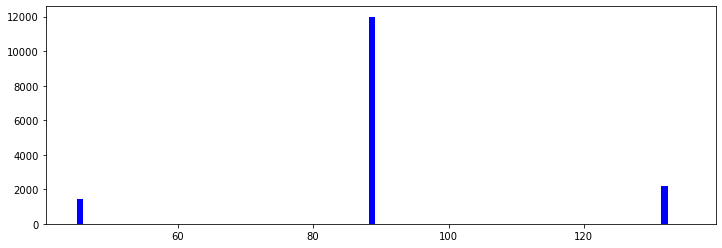

In [34]:
num_of_bins=25
hist,bins=np.histogram(df['Angle'],num_of_bins)

fig,axes=plt.subplots(1,1,figsize=(12,4))
axes.hist(df['Angle'],bins=num_of_bins,width=1,color='blue')

#### 학습데이터, 검증데이터 분리

Training data: 12494
Validation data: 3124


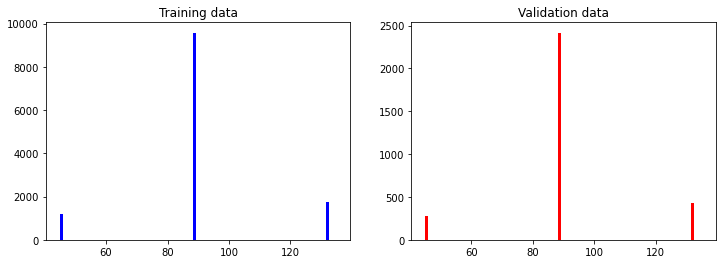

In [35]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steering_angles,test_size=0.2)
# 데이터 크기 출력
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# 히스토그램 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation data')

plt.show()

#### 이미지 읽어오고 정규화

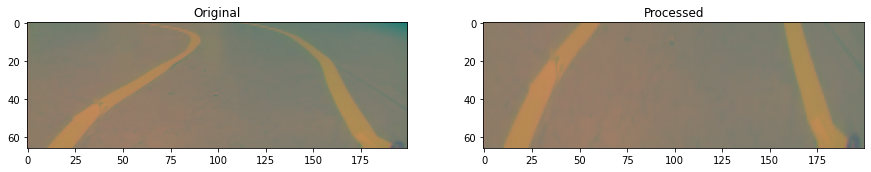

In [36]:
import cv2
import matplotlib.pyplot as plt

# 이미지 전처리 함수
def my_imread(image_path):
    return cv2.imread(image_path)

def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):, :, :]  # 하단 절반 사용
    image = cv2.resize(image, (200, 66))  # 크기 조정
    image = image / 255.0  # 정규화
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))  # 이 부분을 fig, axes로 바꿔야 함
image_orig = my_imread(image_paths[image_index])  # image_paths와 image_index는 정의되어 있어야 함
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("Original") 
axes[1].imshow(image_processed)
axes[1].set_title("Processed")  

plt.show()

#### nvida 모델 구성

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def nvidia_model():
    model = Sequential(name='nvidia_model')
    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding='same', input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), padding='same', activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), padding='same', activation='elu'))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='elu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='elu'))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    
    # Output layer with sigmoid activation and scaling by 180
    model.add(Lambda(lambda x: 180 * tf.keras.activations.sigmoid(x)))
    
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

model = nvidia_model()
model.summary()



Model: "nvidia_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 33, 100, 24)       1824      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 17, 50, 36)        21636     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 9, 25, 48)         43248     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 13, 64)         27712     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 5, 13, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 4160)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4160)             

#### 학습 데이터 생성

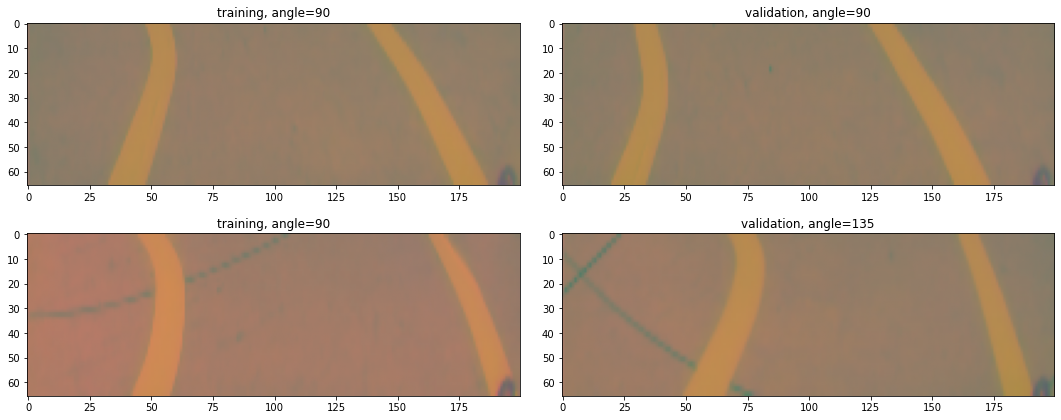

In [38]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_path)
            steering_angle=steering_angles[random_index]

            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)

        yield (np.array(batch_images), np.array(batch_steering_angles))

ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])


#### 모델 학습하기

In [42]:
import os
import tensorflow as tf
import pickle

# 모델 저장 디렉토리 설정
model_output_dir = "../new_lane"

# 체크포인트 콜백 설정
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_output_dir, 'lane_navigation_new_check.h5'), 
    verbose=1, 
    save_best_only=True
)

# 모델 학습
history = model.fit_generator(
    image_data_generator(X_train, y_train, batch_size=128),
    steps_per_epoch=300,
    validation_data=image_data_generator(X_valid, y_valid, batch_size=128),
    validation_steps=200,
    epochs=10,
    callbacks=[checkpoint_callback],
    verbose=1,
    shuffle=True
)

# 최종 모델 저장
model.save(os.path.join(model_output_dir, 'lane_navigation_new_final.h5'))

# 학습 이력 저장
history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)


Epoch 1/10
200/300 [===================>..........] - ETA: 16s - loss: 451.0041
Epoch 00001: val_loss improved from inf to 451.00412, saving model to ../new_lane\lane_navigation_new_check.h5
300/300 [==============================] - 154s 513ms/step - loss: 533.8652 - val_loss: 451.0041
Epoch 2/10
200/300 [===================>..........] - ETA: 14s - loss: 369.8689
Epoch 00002: val_loss improved from 451.00412 to 369.86888, saving model to ../new_lane\lane_navigation_new_check.h5
300/300 [==============================] - 146s 488ms/step - loss: 420.8490 - val_loss: 369.8689
Epoch 3/10
200/300 [===================>..........] - ETA: 13s - loss: 458.0253
Epoch 00003: val_loss did not improve from 369.86888
300/300 [==============================] - 144s 479ms/step - loss: 510.4041 - val_loss: 458.0253
Epoch 4/10
200/300 [===================>..........] - ETA: 14s - loss: 458.8697
Epoch 00004: val_loss did not improve from 369.86888
300/300 [==============================] - 144s 480ms/s

KeyboardInterrupt: 

In [43]:
import os
import tensorflow as tf
import pickle

# 모델 저장 디렉토리 설정
model_output_dir = "../new_lane"
checkpoint_path = os.path.join(model_output_dir, 'lane_navigation_new_check.h5')

# 기존 모델이 있으면 로드하고, 없으면 새로운 모델 생성
if os.path.exists(checkpoint_path):
    print("Loading model from checkpoint...")
    model = tf.keras.models.load_model(checkpoint_path)
else:
    print("No checkpoint found, creating a new model...")
    # 모델 정의 (여기서는 기존 모델 정의 부분이 필요함)
    # model = create_model()

# 체크포인트 콜백 설정
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_best_only=True
)

# 모델 학습
history = model.fit_generator(
    image_data_generator(X_train, y_train, batch_size=32),
    steps_per_epoch=300,
    validation_data=image_data_generator(X_valid, y_valid, batch_size=32),
    validation_steps=200,
    epochs=10,  # 추가 학습할 에폭 수
    callbacks=[checkpoint_callback],
    verbose=1,
    shuffle=True
)

# 최종 모델 저장
model.save(os.path.join(model_output_dir, 'lane_navigation_new_final.h5'))

# 학습 이력 저장
history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)


Loading model from checkpoint...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/10
200/300 [===================>..........] - ETA: 4s - loss: 452.7784
Epoch 00001: val_loss improved from inf to 452.77838, saving model to ../new_lane\lane_navigation_new_check.h5
300/300 [==============================] - 45s 150ms/step - loss: 431.7571 - val_loss: 452.7784
Epoch 2/10
200/300 [===================>..........] - ETA: 5s - loss: 328.5338
Epoch 00002: val_loss improved from 452.77838 to 328.53381, saving model to ../new_lane\lane_navigation_new_check.h5
300/300 [==============================] - 47s 156ms/step - loss: 396.6164 - val_loss: 328.5338
Epoch 3/10
200/300 [===================>..........] - ETA: 4s - loss: 282.5975
Epoch 00003: val_loss improved from 328.53381 to 282.59753, saving model t

c:\Users\seodongju\anaconda3\envs\aicar_373\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Legend does not support 'training loss' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.


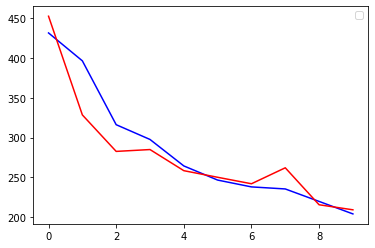

In [44]:
history.history

history_path=os.path.join(model_output_dir,'history.pickle')
with open(history_path,'rb') as f:
    history=pickle.load(f)

history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss"],"validation loss")

In [45]:
import os
import tensorflow as tf
import pickle

# 모델 저장 디렉토리 설정
model_output_dir = "../new_lane"
checkpoint_path = os.path.join(model_output_dir, 'lane_navigation_new_check.h5')

# 기존 모델이 있으면 로드하고, 없으면 새로운 모델 생성
if os.path.exists(checkpoint_path):
    print("Loading model from checkpoint...")
    model = tf.keras.models.load_model(checkpoint_path)
else:
    print("No checkpoint found, creating a new model...")
    # 모델 정의 (여기서는 기존 모델 정의 부분이 필요함)
    # model = create_model()

# 체크포인트 콜백 설정
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_best_only=True
)

# 모델 학습
history = model.fit_generator(
    image_data_generator(X_train, y_train, batch_size=64),
    steps_per_epoch=300,
    validation_data=image_data_generator(X_valid, y_valid, batch_size=64),
    validation_steps=200,
    epochs=10,  # 추가 학습할 에폭 수
    callbacks=[checkpoint_callback],
    verbose=1,
    shuffle=True
)

# 최종 모델 저장
model.save(os.path.join(model_output_dir, 'lane_navigation_new_final.h5'))

# 학습 이력 저장
history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)


Loading model from checkpoint...
Epoch 1/10
200/300 [===================>..........] - ETA: 8s - loss: 175.1607
Epoch 00001: val_loss improved from inf to 175.16074, saving model to ../new_lane\lane_navigation_new_check.h5
300/300 [==============================] - 81s 269ms/step - loss: 163.7611 - val_loss: 175.1607
Epoch 2/10
200/300 [===================>..........] - ETA: 8s - loss: 143.2184
Epoch 00002: val_loss improved from 175.16074 to 143.21842, saving model to ../new_lane\lane_navigation_new_check.h5
300/300 [==============================] - 83s 278ms/step - loss: 137.9941 - val_loss: 143.2184
Epoch 3/10
200/300 [===================>..........] - ETA: 7s - loss: 136.6554
Epoch 00003: val_loss improved from 143.21842 to 136.65536, saving model to ../new_lane\lane_navigation_new_check.h5
300/300 [==============================] - 79s 262ms/step - loss: 113.9018 - val_loss: 136.6554
Epoch 4/10
200/300 [===================>..........] - ETA: 7s - loss: 130.2226
Epoch 00004: val_l

c:\Users\seodongju\anaconda3\envs\aicar_373\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Legend does not support 'training loss' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.


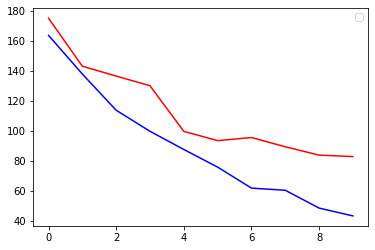

In [46]:
history.history

history_path=os.path.join(model_output_dir,'history.pickle')
with open(history_path,'rb') as f:
    history=pickle.load(f)

history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss"],"validation loss")

In [47]:
import os
import tensorflow as tf
import pickle

# 모델 저장 디렉토리 설정
model_output_dir = "../new_lane"
checkpoint_path = os.path.join(model_output_dir, 'lane_navigation_new_check.h5')

# 기존 모델이 있으면 로드하고, 없으면 새로운 모델 생성
if os.path.exists(checkpoint_path):
    print("Loading model from checkpoint...")
    model = tf.keras.models.load_model(checkpoint_path)
else:
    print("No checkpoint found, creating a new model...")
    # 모델 정의 (여기서는 기존 모델 정의 부분이 필요함)
    # model = create_model()

# 체크포인트 콜백 설정
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_best_only=True
)

# 모델 학습
history = model.fit_generator(
    image_data_generator(X_train, y_train, batch_size=64),
    steps_per_epoch=300,
    validation_data=image_data_generator(X_valid, y_valid, batch_size=64),
    validation_steps=200,
    epochs=10,  # 추가 학습할 에폭 수
    callbacks=[checkpoint_callback],
    verbose=1,
    shuffle=True
)

# 최종 모델 저장
model.save(os.path.join(model_output_dir, 'lane_navigation_new_final.h5'))

# 학습 이력 저장
history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)


Loading model from checkpoint...
Epoch 1/10
200/300 [===================>..........] - ETA: 7s - loss: 71.1201
Epoch 00001: val_loss improved from inf to 71.12010, saving model to ../new_lane\lane_navigation_new_check.h5
300/300 [==============================] - 80s 268ms/step - loss: 38.5042 - val_loss: 71.1201
Epoch 2/10
200/300 [===================>..........] - ETA: 8s - loss: 68.1241
Epoch 00002: val_loss improved from 71.12010 to 68.12413, saving model to ../new_lane\lane_navigation_new_check.h5
300/300 [==============================] - 84s 281ms/step - loss: 32.8656 - val_loss: 68.1241
Epoch 3/10
200/300 [===================>..........] - ETA: 7s - loss: 77.0213
Epoch 00003: val_loss did not improve from 68.12413
300/300 [==============================] - 78s 262ms/step - loss: 39.4861 - val_loss: 77.0213
Epoch 4/10
200/300 [===================>..........] - ETA: 8s - loss: 83.4603
Epoch 00004: val_loss did not improve from 68.12413
300/300 [==============================] - 8

c:\Users\seodongju\anaconda3\envs\aicar_373\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Legend does not support 'training loss' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.


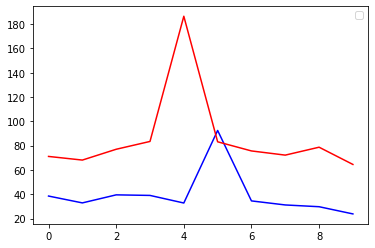

In [48]:
history.history

history_path=os.path.join(model_output_dir,'history.pickle')
with open(history_path,'rb') as f:
    history=pickle.load(f)

history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss"],"validation loss")

mse=8.0
r_squared=97.05%



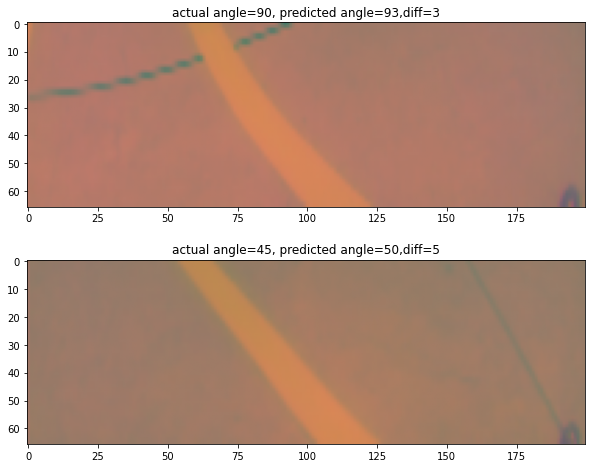

In [49]:
from sklearn.metrics import mean_squared_error,r2_score

def summarize_prediction(Y_true,Y_pred):
    mse=mean_squared_error(Y_true,Y_pred)
    r_squared=r2_score(Y_true,Y_pred)

    print(f'mse={mse:.2}')
    print(f'r_squared={r_squared:.2%}')
    print()

def predict_and_summarize(X,Y):
    model=load_model('../new_lane/lane_navigation_new_final.h5')
    Y_pred=model.predict(X)
    summarize_prediction(Y,Y_pred)
    return Y_pred

n_tests=100
X_test,y_test=next(image_data_generator(X_valid,y_valid,100))

y_pred=predict_and_summarize(X_test,y_test)

n_tests_show=2
fig,axes=plt.subplots(n_tests_show,1,figsize=(10,4*n_tests_show))

for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])},diff={int(y_pred[i])-y_test[i]}")